In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from numpy.linalg import inv

## Load CSV file

In [3]:
df = pd.read_csv("../raw_dataset/musculo2.csv")

t = [df["0"][list(df["0"]).index(8.05) + i] 
    for i in range(list(df["0"]).index(10.1) - list(df["0"]).index(8))]
t_2 = pd.DataFrame(t).iloc[:].values

sig = [df["0.21569"][list(df["0"]).index(8.05) + i] 
    for i in range(list(df["0"]).index(10.1) - list(df["0"]).index(8))]
sig_2 = pd.DataFrame(sig).iloc[:].values

## Original Signal

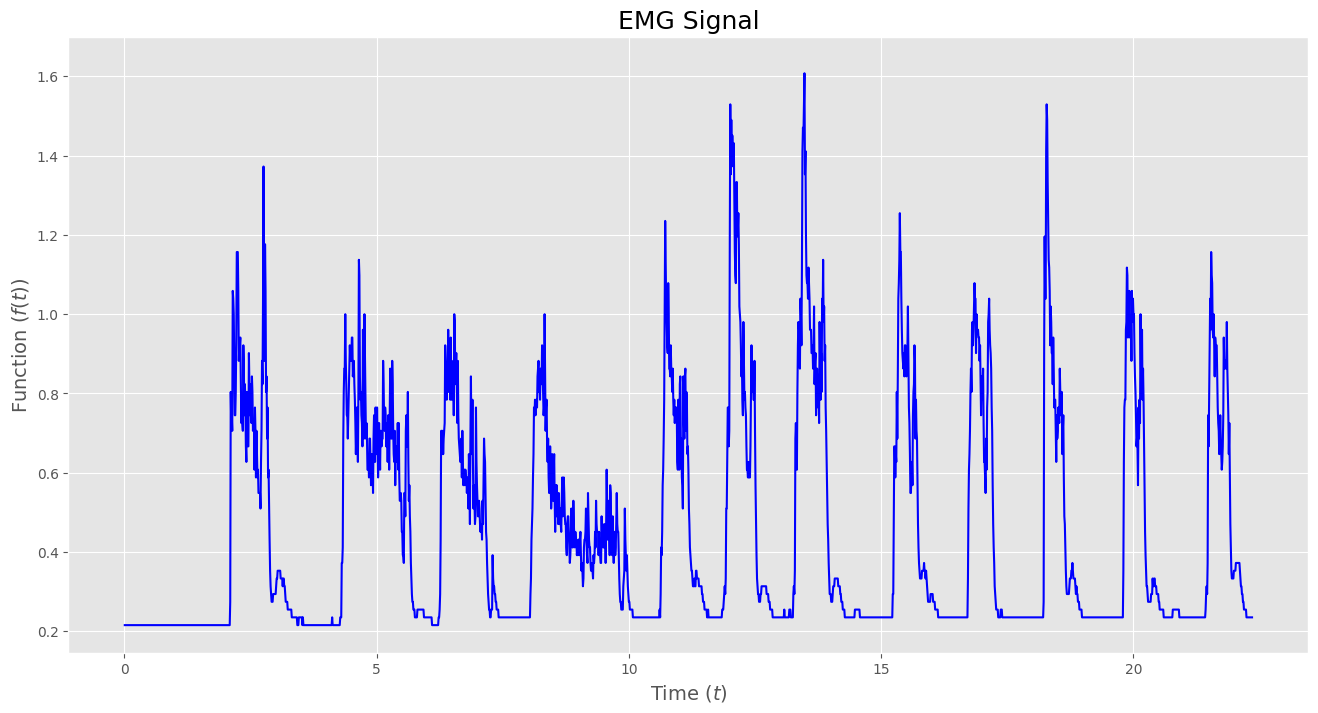

In [4]:
plt.style.use('ggplot')
plt.figure(figsize = (16, 8))
plt.title(r'EMG Signal', size=18)
plt.plot(df["0"], df["0.21569"],'b')
plt.ylabel(r'Function $(f(t))$', size=14)
plt.xlabel(r'Time $(t)$', size=14)
plt.ylim(top = 1.7)
plt.xlim()
plt.show()

## Ploynomial Function

In [5]:
poly = PolynomialFeatures(degree = 7)
X_poly = poly.fit_transform(t_2)
poly.fit(X_poly, sig_2)
lin2 = LinearRegression()
lin2.fit(X_poly, sig_2)

LinearRegression()

## Gradient Descent

In [37]:
def gradient_descent(start, y, X, learn_rate, max_iter, tol=0.001):
  steps = [start] 
  x = start
  for _ in range(max_iter):
    if x not in X:
      diff = 0
    else:  
      diff = -learn_rate*y[X.index(round(x,2))] 
    x = float('{0:.2f}'.format(x - diff))
    steps.append(x) 
  return steps, x

In [68]:
gradient = gradient_descent(9.5, sig, t, 0.2, 101)
new_time = sorted(set(gradient[0]))
new_gradient = [lin2.predict(poly.fit_transform(t_2)).tolist()[t.index(new_time[:len(new_time)-1][i])][0]
for i in range(len(new_time[:len(new_time)-1]))]

## Stochastic Gradient Descent

In [136]:
def sgd(x,y,lr,it):
    x = np.array(x)
    ones = np.ones(shape=(x.shape[0],1))
    x = np.concatenate((ones, x.reshape(-1,1)), axis=1)
    y = np.array(y)
    W = np.zeros(shape=(x.shape[1],1))
    all_W = list()
    for i in range(it):
        y_p = x @ W
        dW = np.dot(x.T, y_p - y)
        W = W - lr * dW
        all_W.append(W)
    return all_W

poly_list = [lin2.predict(poly.fit_transform(t_2)).tolist()[i][0]
for i in range(len(t))]

stoch_gd = sgd(new_time,new_gradient,0.01,10)
stoch_gd = np.array(stoch_gd)[0][1] - np.array(stoch_gd)[0][0]

## Plot 

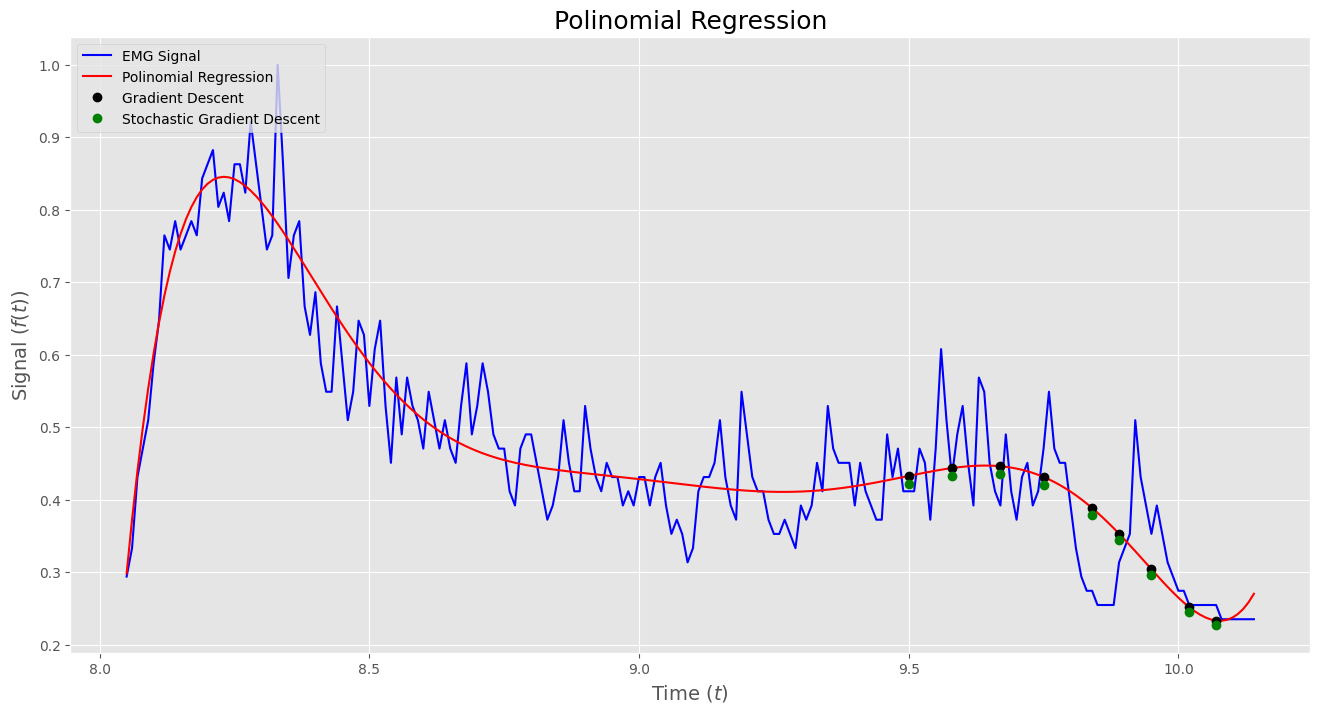

In [137]:
plt.style.use('ggplot')
plt.figure(figsize = (16, 8))
plt.title('Polinomial Regression', size=18)
plt.plot(t,sig,'b', label=r'EMG Signal')
plt.plot(t_2, lin2.predict(poly.fit_transform(t_2)),'r', label=r'Polinomial Regression')
plt.plot(new_time[:len(new_time)-2], new_gradient[:len(new_gradient)-1], 'ko', label=r'Gradient Descent')
plt.plot(new_time[:len(new_time)-2], stoch_gd[:len(new_gradient)-1].tolist(), 'go', label=r'Stochastic Gradient Descent')

plt.ylabel(r'Signal $(f(t))$', size=14)
plt.xlabel(r'Time $(t)$', size=14)
plt.legend(loc = "upper left")
#plt.ylim(top = 1.2)
plt.show()

In [41]:
pred2 = 10.0
pred2array = np.array([[pred2]])
lin2.predict(poly.fit_transform(pred2array))

array([[0.31680921]])

In [132]:
def Griewank(xs):
    """Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    
    sigma = np.dot(xs, xs) / 4000
    pi = np.prod(cos_terms)
    return 1 + sigma - pi

def GriewankGrad(xs):
    """First derivative of Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    pi_coefs = np.prod(cos_terms) / cos_terms
    
    sigma = 2 * xs / 4000
    pi = pi_coefs * np.sin(xs / sqrts) * (1 / sqrts)
    return sigma + pi

In [142]:
def ArmijoLineSearch(f, xk, pk, gfk, phi0, alpha0, rho=0.5, c1=1e-4):
    """Minimize over alpha, the function ``f(xₖ + αpₖ)``.
    α > 0 is assumed to be a descent direction.
    
    Parameters
    --------------------
    f : callable
        Function to be minimized.
    xk : array
        Current point.
    pk : array
        Search direction.
    gfk : array
        Gradient of `f` at point `xk`.
    phi0 : float
        Value of `f` at point `xk`.
    alpha0 : scalar
        Value of `alpha` at the start of the optimization.
    rho : float, optional
        Value of alpha shrinkage factor.
    c1 : float, optional
        Value to control stopping criterion.
    
    Returns
    --------------------
    alpha : scalar
        Value of `alpha` at the end of the optimization.
    phi : float
        Value of `f` at the new point `x_{k+1}`.
    """
    derphi0 = np.dot(gfk, pk)
    phi_a0 = f(xk + alpha0*pk)
    
    while not phi_a0 <= phi0 + c1*alpha0*derphi0:
        alpha0 = alpha0 * rho
        phi_a0 = f(xk + alpha0*pk)
    
    return alpha0, phi_a0

In [150]:
def GradientDescent(f, f_grad, init, alpha=1, tol=1e-5, max_iter=1000):
    """Gradient descent method for unconstraint optimization problem.
    given a starting point x ∈ Rⁿ,
    repeat
        1. Define direction. p := −∇f(x).
        2. Line search. Choose step length α using Armijo Line Search.
        3. Update. x := x + αp.
    until stopping criterion is satisfied.
    
    Parameters
    --------------------
    f : callable
        Function to be minimized.
    f_grad : callable
        The first derivative of f.
    init : array
        initial value of x.
    alpha : scalar, optional
        the initial value of steplength.
    tol : float, optional
        tolerance for the norm of f_grad.
    max_iter : integer, optional
        maximum number of steps.
    
    Returns
    --------------------
    xs : array
        x in the learning path
    ys : array
        f(x) in the learning path
    """
    # initialize x, f(x), and f'(x)
    xk = init    
    fk = f
    gfk = f_grad
    gfk_norm = np.linalg.norm(gfk)
    # initialize number of steps, save x and f(x)
    num_iter = 0
    curve_x = [xk]
    curve_y = [fk]
    print('Initial condition: y = {:.4f}, x = {} \n'.format(fk, xk))
    # take steps
    while gfk_norm > tol and num_iter < max_iter:
        # determine direction
        pk = -gfk
        # calculate new x, f(x), and f'(x)
        alpha, fk = ArmijoLineSearch(f, xk, pk, gfk, fk, alpha0=alpha)
        xk = xk + alpha * pk
        gfk = f_grad(xk)
        gfk_norm = np.linalg.norm(gfk)
        # increase number of steps by 1, save new x and f(x)
        num_iter += 1
        curve_x.append(xk)
        curve_y.append(fk)
        print('Iteration: {} \t y = {:.4f}, x = {}, gradient = {:.4f}'.
              format(num_iter, fk, xk, gfk_norm))
    # print results
    if num_iter == max_iter:
        print('\nGradient descent does not converge.')
    else:
        print('\nSolution: \t y = {:.4f}, x = {}'.format(fk, xk))
    
    return np.array(curve_x), np.array(curve_y)

In [151]:
x0 = np.array([0, 3])
xs, ys = GradientDescent(Griewank(np.array(signal)), GriewankGrad(np.array(signal)), init=x0)

Initial condition: y = 0.5662, x = [0 3] 



ValueError: operands could not be broadcast together with shapes (2,) (99,) 

In [141]:
sigma = 2 * signal.sum() / 4000

AttributeError: 'list' object has no attribute 'sum'